In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("EURUSD_H1_202201030000_202504111800.csv", sep="\t")
df.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2022.01.03,00:00:00,1.13693,1.13742,1.13645,1.13726,571,0,17
1,2022.01.03,01:00:00,1.13725,1.13778,1.13687,1.13728,1345,0,7
2,2022.01.03,02:00:00,1.13728,1.13759,1.13608,1.13622,1054,0,1
3,2022.01.03,03:00:00,1.13622,1.13654,1.13497,1.13588,1349,0,1
4,2022.01.03,04:00:00,1.13588,1.13589,1.13422,1.13427,1091,0,1


In [3]:
import matplotlib.pyplot as plt

df['datetime'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df.set_index('datetime', inplace=True)
df = df.rename(columns={
    '<OPEN>':  'Open',
    '<HIGH>':  'High',
    '<LOW>':   'Low',
    '<CLOSE>': 'Close',
    '<TICKVOL>':'Volume',
    '<SPREAD>':'Spread'
})
df = df[['Open','High','Low','Close','Volume','Spread']]
df.head()


,Open,High,Low,Close,Volume,Spread
datetime,,,,,,
2022-01-03 00:00:00,1.13693,1.13742,1.13645,1.13726,571,17
2022-01-03 01:00:00,1.13725,1.13778,1.13687,1.13728,1345,7
2022-01-03 02:00:00,1.13728,1.13759,1.13608,1.13622,1054,1
2022-01-03 03:00:00,1.13622,1.13654,1.13497,1.13588,1349,1
2022-01-03 04:00:00,1.13588,1.13589,1.13422,1.13427,1091,1


In [17]:

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# 1) (You’ll already have loaded and prepared your H1 df with columns
#     Open, High, Low, Close, Volume, Spread and a DateTime index.)

# 2) Strategy
class EMA_RSI_ATR(Strategy):
    fast, slow           = 20, 60
    rsi_period, atr_period = 14, 14
    atr_mult, rrr        = 2, 1.5

    def init(self):
        # pull true pandas Series via the .s accessor
        close_s = self.data.Close.s
        high_s  = self.data.High.s
        low_s   = self.data.Low.s

        # EMA20 & EMA50
        self.ema_fast = self.I(
            lambda s: s.ewm(span=self.fast, adjust=False).mean(),
            close_s
        )
        self.ema_slow = self.I(
            lambda s: s.ewm(span=self.slow, adjust=False).mean(),
            close_s
        )

        # RSI(14)
        delta    = close_s.diff()
        gain     = delta.clip(lower=0)
        loss     = -delta.clip(upper=0)
        self.rsi = self.I(
            lambda g, l: 100 - 100/(1 + (g.ewm(alpha=1/self.rsi_period, min_periods=self.rsi_period).mean() / 
                                         l.ewm(alpha=1/self.rsi_period, min_periods=self.rsi_period).mean())),
            gain, loss
        )

        # True Range series
        tr = pd.concat([
            high_s - low_s,
            (high_s - close_s.shift()).abs(),
            (low_s  - close_s.shift()).abs()
        ], axis=1).max(axis=1)

        # ATR(14) — wrap rolling().mean() in a lambda so I() gets a Series
        self.atr = self.I(
            lambda s: s.rolling(self.atr_period).mean(),
            tr
        )

    def next(self):
        if self.position:
            return

        # Long entry
        if crossover(self.ema_fast, self.ema_slow) and self.rsi[-1] > 50:
            e = self.data.Close[-1]
            sl = e - self.atr[-1] * self.atr_mult
            tp = e + self.atr[-1] * self.atr_mult * self.rrr
            self.buy(sl=sl, tp=tp)

        # Short entry
        elif crossover(self.ema_slow, self.ema_fast) and self.rsi[-1] < 50:
            e = self.data.Close[-1]
            sl = e + self.atr[-1] * self.atr_mult
            tp = e - self.atr[-1] * self.atr_mult * self.rrr
            self.sell(sl=sl, tp=tp)

# 3) Run the backtest
bt = Backtest(
    df,
    EMA_RSI_ATR,
    cash=100000,
    commission=0.0002,
    trade_on_close=False,
    margin=1/50
)

stats = bt.run()
bt.plot()
print(stats)



C:\Users\Rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '4h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


Start                     2022-01-03 00:00:00
End                       2025-04-11 18:00:00
Duration                   1194 days 18:00:00
Exposure Time [%]                    25.45811
Equity Final [$]                       0.6853
Equity Peak [$]                  172461.93363
Commissions [$]                     50205.459
Return [%]                          -99.99931
Buy & Hold Return [%]                -0.29757
Return (Ann.) [%]                   -97.03118
Volatility (Ann.) [%]                17.44333
CAGR [%]                            -91.85728
Sharpe Ratio                         -5.56265
Sortino Ratio                        -0.69258
Calmar Ratio                         -0.97032
Alpha [%]                          -100.09369
Beta                                 -0.31714
Max. Drawdown [%]                    -99.9996
Avg. Drawdown [%]                   -41.26221
Max. Drawdown Duration     1126 days 22:00:00
Avg. Drawdown Duration      296 days 06:00:00
# Trades                          

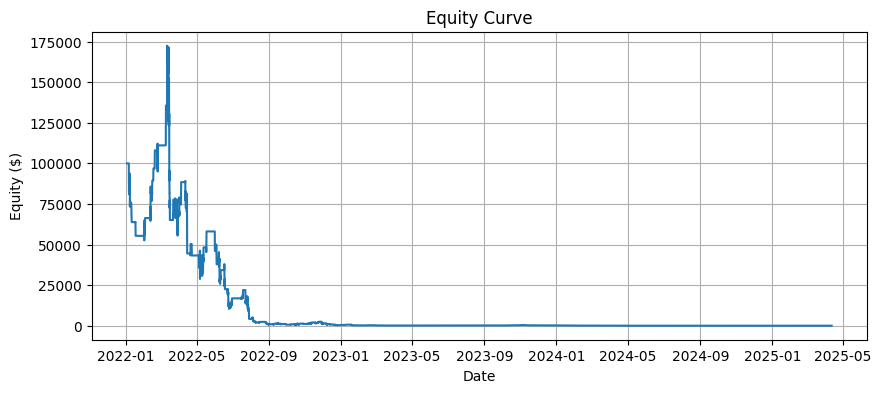

In [18]:
import matplotlib.pyplot as plt

# pull out the equity DataFrame
eq = stats._equity_curve['Equity']

plt.figure(figsize=(10,4))
plt.plot(eq.index, eq.values)
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.grid(True)
plt.show()


In [5]:
total_rows =len(df)
split_index = int(total_rows*0.7)
df_is = df.iloc[:split_index]
df_oos = df.iloc[split_index:]
df_oos.head()

,Open,High,Low,Close,Volume,Spread
datetime,,,,,,
2024-04-17 16:00:00,1.06343,1.06525,1.06341,1.06438,5199,3
2024-04-17 17:00:00,1.06439,1.06443,1.06298,1.06352,5733,4
2024-04-17 18:00:00,1.06353,1.06460,1.06353,1.06428,5434,3
2024-04-17 19:00:00,1.06429,1.06560,1.06358,1.06495,6101,4
2024-04-17 20:00:00,1.06496,1.06685,1.06476,1.06680,4717,5


In [15]:
bt = Backtest(
    df_is,
    EMA_RSI_ATR,
    cash=10_000,
    commission=0.0002,
    trade_on_close=False,
    margin=1/50
)
best_stats = bt.optimize(
    fast       = range(10, 21, 5),
    slow       = range(60, 81, 10),
    rsi_period = [14, 20],
    atr_mult   = [1.5, 2.0],
    rrr        = [1.5, 2.0],
    maximize   = 'Sharpe Ratio',
    constraint = lambda p: p.fast < p.slow
)

# Under the hood backtesting.py injects the winning params into the Strategy
strategy_obj = best_stats._strategy      # private API
print("Fast EMA:", strategy_obj.fast)
print("Slow EMA:", strategy_obj.slow)
print("RSI period:", strategy_obj.rsi_period)
print("ATR mult:", strategy_obj.atr_mult)
print("RRR:", strategy_obj.rrr)


C:\Users\Rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\backtesting.py:1606: RuntimeWarning: If you want to use multi-process optimization with `multiprocessing.get_start_method() == 'spawn'` (e.g. on Windows),set `backtesting.Pool = multiprocessing.Pool` (or of the desired context) and hide `bt.optimize()` call behind a `if __name__ == '__main__'` guard. Currently using thread-based paralellism, which might be slightly slower for non-numpy / non-GIL-releasing code. See https://github.com/kernc/backtesting.py/issues/1256
  output = _optimize_grid()
Backtest.optimize:   0%|          | 0/72 [00:00<?, ?it/s]














C:\Users\Rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\backtesting.py:954: UserWarning: time=13648: Broker canceled the relative-sized order due to insufficient margin.
  warnings.wa

Fast EMA: 20
Slow EMA: 60
RSI period: 14
ATR mult: 2.0
RRR: 1.5


None
